# Denoising scRNA-seq using DCA

## scRNA-seq Simulation using Splatter R package and rpy2

In [1]:
# make sure that rpy2 is installed: https://rpy2.bitbucket.io/
%load_ext rpy2.ipython

import warnings
from rpy2.rinterface import RRuntimeWarning

# ignore R warning messages
warnings.filterwarnings("ignore", category=RRuntimeWarning)

### Simulate two groups using Splatter

In [2]:
%%R -o counts -o truecounts -o geneinfo -o cellinfo

# make sure that splatter is installed: https://github.com/Oshlack/splatter
library(splatter)

simulate <- function(nGroups=2, nGenes=200, batchCells=2000, dropout=3)
{
    if (nGroups > 1) method <- 'groups'
    else             method <- 'single'

    group.prob <- rep(1, nGroups) / nGroups

    # new splatter requires dropout.type
    if ('dropout.type' %in% slotNames(newSplatParams())) {
        if (dropout)
            dropout.type <- 'experiment'
        else
            dropout.type <- 'none'
        
        sim <- splatSimulate(group.prob=group.prob, nGenes=nGenes, batchCells=batchCells,
                             dropout.type=dropout.type, method=method,
                             seed=42, dropout.shape=-1, dropout.mid=dropout)

    } else {
        sim <- splatSimulate(group.prob=group.prob, nGenes=nGenes, batchCells=batchCells,
                             dropout.present=!dropout, method=method,
                             seed=42, dropout.shape=-1, dropout.mid=dropout)        
    }

    counts     <- as.data.frame(t(counts(sim)))
    truecounts <- as.data.frame(t(assays(sim)$TrueCounts))

    dropout    <- assays(sim)$Dropout
    mode(dropout) <- 'integer'

    cellinfo   <- as.data.frame(colData(sim))
    geneinfo   <- as.data.frame(rowData(sim))

    list(counts=counts,
         cellinfo=cellinfo,
         geneinfo=geneinfo,
         truecounts=truecounts)
}

sim <- simulate()

counts <- sim$counts
geneinfo <- sim$geneinfo
cellinfo <- sim$cellinfo
truecounts <- sim$truecounts

/Users/david/anaconda3/envs/DESC/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


## Generate AnnData objects and analyze in Scanpy

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy.api as sc
from desc.models import train

In [5]:
adata = sc.AnnData(counts.values, obs=cellinfo, var=geneinfo)
adata.obs_names = cellinfo.Cell
adata.var_names = geneinfo.Gene
sc.pp.filter_genes(adata, min_counts=1)
adata

AnnData object with n_obs × n_vars = 2000 × 198 
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'n_counts'

In [6]:
adata_true = sc.AnnData(truecounts.values, obs=cellinfo, var=geneinfo)
adata_true.obs_names = cellinfo.Cell
adata_true.var_names = geneinfo.Gene
adata_true = adata_true[:, adata.var_names].copy()
adata_true

AnnData object with n_obs × n_vars = 2000 × 198 
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'n_counts'

In [7]:
sc.pp.normalize_per_cell(adata)
sc.pp.normalize_per_cell(adata_true)

sc.pp.log1p(adata)
sc.pp.log1p(adata_true)

sc.pp.pca(adata)
sc.pp.pca(adata_true)

## Denoise simulated data

In [13]:
%%time

adata_ae = sc.AnnData(counts.values, obs=cellinfo, var=geneinfo)
adata_ae.obs_names = cellinfo.Cell
adata_ae.var_names = geneinfo.Gene

sc.pp.filter_genes(adata_ae, min_counts=1)
#dca(adata_ae, threads=1)
adata = train(adata, dims=[198, 100, 50], resolution=1,loss="poisson",is_stacked=False,max_iter=20,pretrain_epochs=300)

sc.pp.normalize_per_cell(adata_ae)
sc.pp.log1p(adata_ae)
sc.pp.pca(adata_ae)

The number of threads in your computer is 12
The number of threads used is 4
Created autoencoder with mean squared error loss.
Checking whether tmp_result/ae_weights,h5  exists in the directory
learning rate = 1
Epoch 1/300
2000/2000 [==============================] - 0s 124us/step - loss: -0.1368
Epoch 2/300
2000/2000 [==============================] - 0s 9us/step - loss: -1.2899
Epoch 3/300
2000/2000 [==============================] - 0s 13us/step - loss: -1.4420
Epoch 4/300
2000/2000 [==============================] - 0s 10us/step - loss: -1.4649
Epoch 5/300
2000/2000 [==============================] - 0s 13us/step - loss: -1.4638
Epoch 6/300
2000/2000 [==============================] - 0s 10us/step - loss: -1.4665
Epoch 7/300
2000/2000 [==============================] - 0s 12us/step - loss: -1.4656
Epoch 8/300
2000/2000 [==============================] - 0s 13us/step - loss: -1.4646
Epoch 9/300
2000/2000 [==============================] - 0s 8us/step - loss: -1.4663
Epoch 10/300
20

2000/2000 [==============================] - 0s 11us/step - loss: -1.4627 - clustering_loss: 1.6382e-07 - output_loss: -1.4627
Epoch 2/4
2000/2000 [==============================] - 0s 12us/step - loss: -1.4698 - clustering_loss: 1.2516e-07 - output_loss: -1.4698
Epoch 3/4
2000/2000 [==============================] - 0s 11us/step - loss: -1.4671 - clustering_loss: 1.4979e-07 - output_loss: -1.4671
Epoch 4/4
2000/2000 [==============================] - 0s 12us/step - loss: -1.4671 - clustering_loss: 1.1388e-07 - output_loss: -1.4671
The value of delta_label of current 10 th iteration is 0.995 >= tol 0.005
Epoch 1/4
2000/2000 [==============================] - 0s 12us/step - loss: -1.4681 - clustering_loss: 1.4006e-07 - output_loss: -1.4681
Epoch 2/4
2000/2000 [==============================] - 0s 12us/step - loss: -1.4662 - clustering_loss: 1.6829e-07 - output_loss: -1.4662
Epoch 3/4
2000/2000 [==============================] - 0s 13us/step - loss: -1.4678 - clustering_loss: 1.6955e-06 

CPU times: user 14.9 s, sys: 1.5 s, total: 16.4 s
Wall time: 8.79 s


In [8]:
adata_ae

AnnData object with n_obs × n_vars = 2000 × 198 
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize', 'n_counts', 'DCA_split', 'size_factors'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'n_counts'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## PCA: Simulation with and without dropout effect

... storing 'Batch' as categorical
... storing 'Group' as categorical


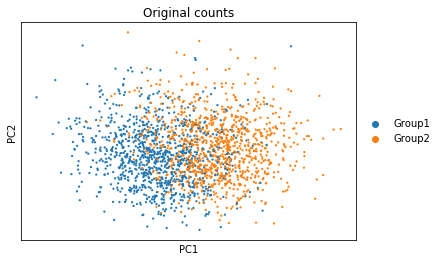

... storing 'Batch' as categorical
... storing 'Group' as categorical


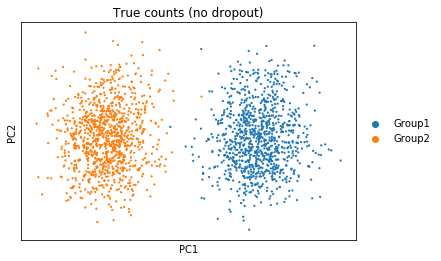

... storing 'Batch' as categorical
... storing 'Group' as categorical


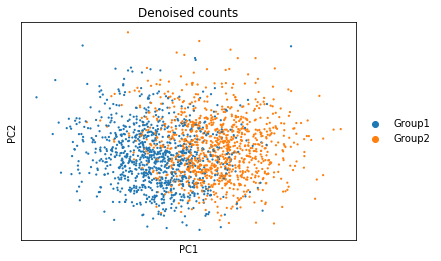

In [14]:
sc.pl.pca_scatter(adata, color='Group', size=20, title='Original counts')
sc.pl.pca_scatter(adata_true, color='Group', size=20, title='True counts (no dropout)')
sc.pl.pca_scatter(adata_ae, color='Group', size=20, title='Denoised counts')

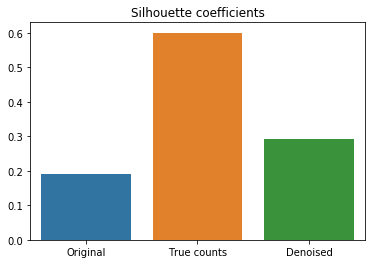

In [10]:
from sklearn.metrics import silhouette_score

sil_orig = silhouette_score(adata.obsm.X_pca[:, :2], adata.obs.Group)
sil_true = silhouette_score(adata_true.obsm.X_pca[:, :2], adata_true.obs.Group)
sil_ae = silhouette_score(adata_ae.obsm.X_pca[:, :2], adata_ae.obs.Group)

sns.barplot(x=['Original', 'True counts', 'Denoised'], 
            y=[sil_orig, sil_true, sil_ae])

plt.title('Silhouette coefficients');

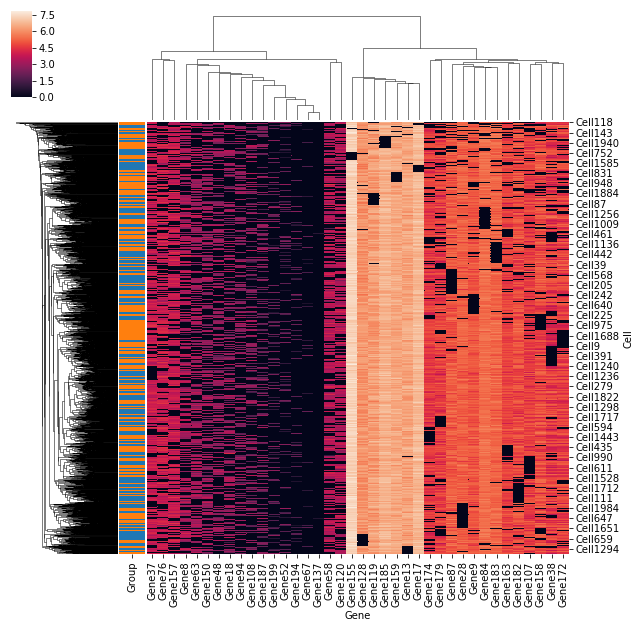

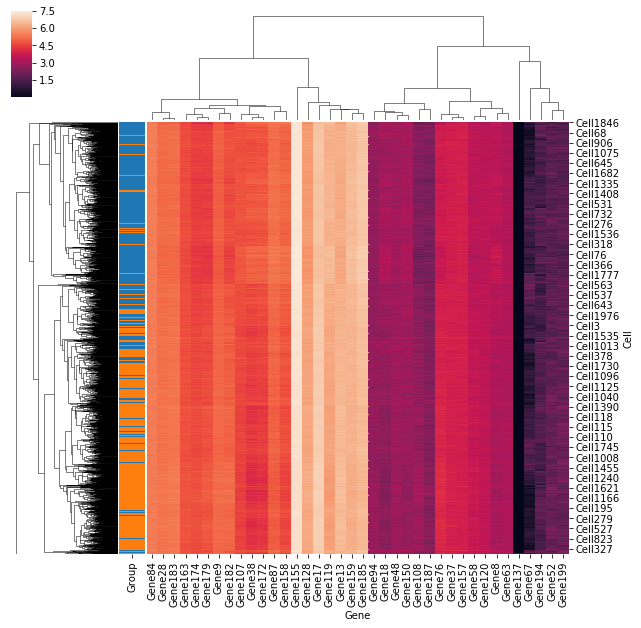

In [11]:
de_genes = (adata.var.loc[:, 'DEFacGroup1':'DEFacGroup2'].values.sum(1) != 2.0)

sc.pl.clustermap(adata[:, de_genes], 'Group', use_raw=False)
sc.pl.clustermap(adata_ae[:, de_genes], 'Group', use_raw=False)

## Simulate six groups

In [33]:
%%R -o counts -o geneinfo -o cellinfo -o truecounts

sim <- simulate(nGroups=6, dropout=1)

counts <- sim$counts
geneinfo <- sim$geneinfo
cellinfo <- sim$cellinfo
truecounts <- sim$truecounts

/Users/david/anaconda3/envs/DESC/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [66]:
adata = sc.AnnData(counts.values, obs=cellinfo, var=geneinfo)
adata.obs_names = cellinfo.Cell
adata.var_names = geneinfo.Gene
sc.pp.filter_genes(adata, min_counts=1)

adata_true = sc.AnnData(truecounts.values, obs=cellinfo, var=geneinfo)
adata_true.obs_names = cellinfo.Cell
adata_true.var_names = geneinfo.Gene
adata_true = adata_true[:, adata.var_names].copy()
adata_true

AnnData object with n_obs × n_vars = 2000 × 199 
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'DEFacGroup3', 'DEFacGroup4', 'DEFacGroup5', 'DEFacGroup6', 'n_counts'

In [67]:
sc.pp.normalize_per_cell(adata)
sc.pp.normalize_per_cell(adata_true)

sc.pp.log1p(adata)
sc.pp.log1p(adata_true)

sc.pp.pca(adata)
sc.pp.pca(adata_true)

sc.tl.tsne(adata)
sc.tl.tsne(adata_true)

## Denoise simulated data

In [25]:
adata

AnnData object with n_obs × n_vars = 2000 × 199 
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize', 'n_counts', 'ident', 'max_prob'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'DEFacGroup3', 'DEFacGroup4', 'DEFacGroup5', 'DEFacGroup6', 'n_counts'
    uns: 'pca', 'Group_colors'
    obsm: 'X_pca', 'X_tsne', 'embedded', 'prob'
    varm: 'PCs'

In [68]:
%%time

adata_ae = sc.AnnData(counts.values, obs=cellinfo, var=geneinfo)
adata_ae.obs_names = cellinfo.Cell
adata_ae.var_names = geneinfo.Gene

sc.pp.filter_genes(adata_ae, min_counts=1)
#dca(adata_ae, threads=1)
adata_ae.X
adata_ae = train(adata_ae, dims=[199, 100, 50], resolution=1,loss="poisson",is_stacked=False,max_iter=20,pretrain_epochs=300)

sc.pp.normalize_per_cell(adata_ae)
sc.pp.log1p(adata_ae)
sc.tl.tsne(adata_ae,use_rep="embedded")

adata_ae

The number of threads in your computer is 12
The number of threads used is 4
Created autoencoder with mean squared error loss.
Checking whether tmp_result/ae_weights,h5  exists in the directory
learning rate = 1
Epoch 1/300
2000/2000 [==============================] - 1s 453us/step - loss: -293.7199
Epoch 2/300
2000/2000 [==============================] - 0s 15us/step - loss: -902.3630
Epoch 3/300
2000/2000 [==============================] - 0s 14us/step - loss: -1489.9562
Epoch 4/300
2000/2000 [==============================] - 0s 14us/step - loss: -1778.0234
Epoch 5/300
2000/2000 [==============================] - 0s 14us/step - loss: -1866.3915
Epoch 6/300
2000/2000 [==============================] - 0s 14us/step - loss: -1879.5577
Epoch 7/300
2000/2000 [==============================] - 0s 14us/step - loss: -1878.9990
Epoch 8/300
2000/2000 [==============================] - 0s 13us/step - loss: -1880.2586
Epoch 9/300
2000/2000 [==============================] - 0s 16us/step - loss:

In [57]:
adata_ae.X

array([[0.7915635 , 0.9609939 , 0.76998335, ..., 1.1041465 , 0.6133616 ,
        1.0015639 ],
       [0.9003915 , 0.92994857, 0.83006597, ..., 1.1175536 , 0.        ,
        1.0048434 ],
       [0.8673283 , 0.9500319 , 0.85657847, ..., 1.0977355 , 0.79578763,
        0.9694913 ],
       ...,
       [0.8992381 , 0.9128734 , 0.        , ..., 1.1236777 , 0.71998936,
        1.0081346 ],
       [0.8755661 , 0.9559463 , 0.8168862 , ..., 1.1280856 , 0.        ,
        1.0192964 ],
       [0.7796339 , 0.9891609 , 0.4576435 , ..., 1.1197152 , 0.        ,
        1.0034106 ]], dtype=float32)

... storing 'Batch' as categorical
... storing 'Group' as categorical


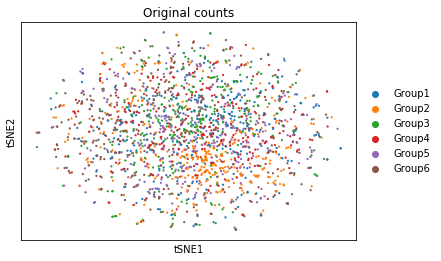

... storing 'Batch' as categorical
... storing 'Group' as categorical


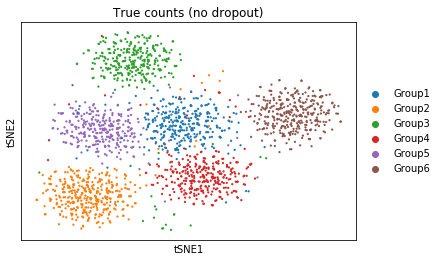

... storing 'Batch' as categorical
... storing 'Group' as categorical


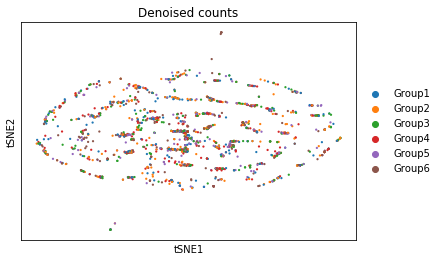

In [69]:
sc.pl.tsne(adata, color='Group', size=20, title='Original counts')
sc.pl.tsne(adata_true, color='Group', size=20, title='True counts (no dropout)')
sc.pl.tsne(adata_ae, color=['Group'], size=20, title='Denoised counts')

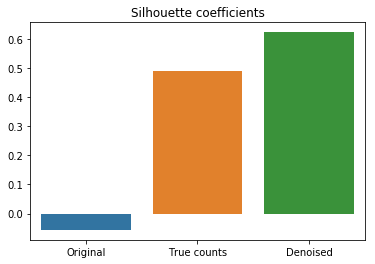

In [17]:
from sklearn.metrics import silhouette_score

sil_orig = silhouette_score(adata.obsm.X_tsne, adata.obs.Group)
sil_true = silhouette_score(adata_true.obsm.X_tsne, adata_true.obs.Group)
sil_ae   = silhouette_score(adata_ae.obsm.X_tsne, adata_ae.obs.Group)

sns.barplot(x=['Original', 'True counts', 'Denoised'], y=[sil_orig, sil_true, sil_ae])
plt.title('Silhouette coefficients');

In [18]:
adata

AnnData object with n_obs × n_vars = 2000 × 199 
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize', 'n_counts'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'DEFacGroup3', 'DEFacGroup4', 'DEFacGroup5', 'DEFacGroup6', 'n_counts'
    uns: 'pca', 'Group_colors'
    obsm: 'X_pca', 'X_tsne'
    varm: 'PCs'

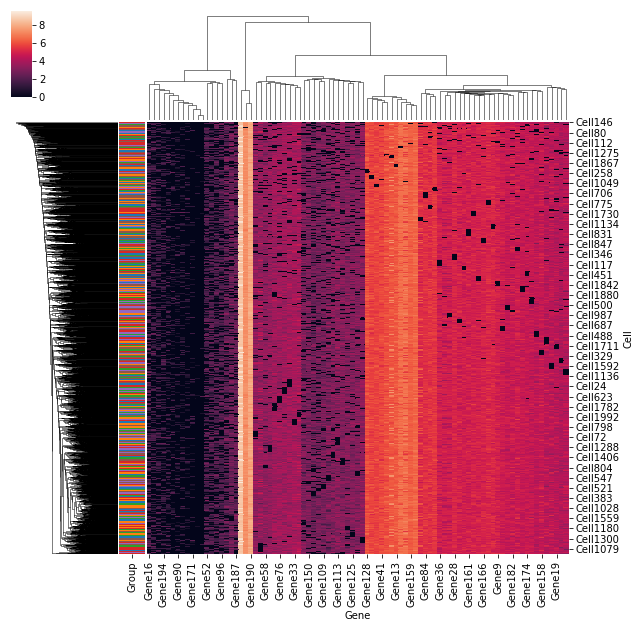

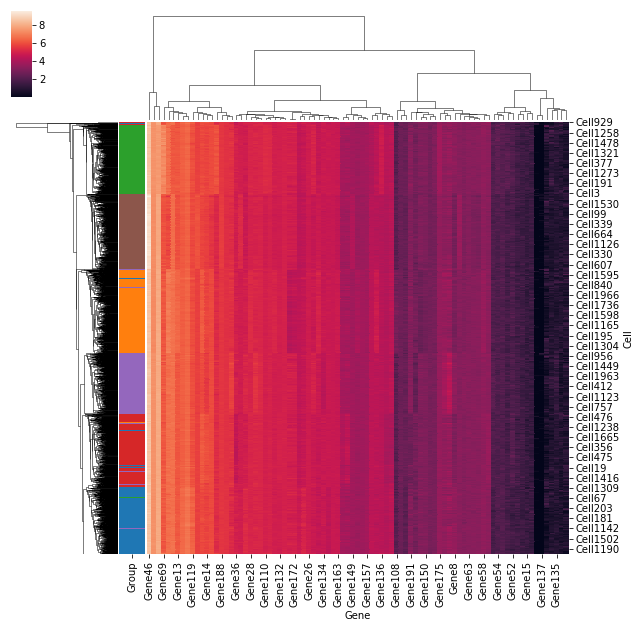

In [19]:
de_genes = (adata.var.loc[:, 'DEFacGroup1':'DEFacGroup6'].values.sum(1) != 6.0)

sc.pl.clustermap(adata[:, de_genes], 'Group', use_raw=False)
sc.pl.clustermap(adata_ae[:, de_genes], 'Group', use_raw=False)